# Sample Size Experiment using Random Forest and Deep Networks

### Random Forest (RF) vs. Deep Networks (DN)

Random forest is inherently a non-parametric model, meaning that the algorithm requires no assumptions about the data distribution. With infinitely many trees and n &rarr; $\infty$, RF will follow non-parametric behavior and will guarantee convergence.

Deep Networks with a fixed architecture are entirely parametric. As presented by [Vogelstein, et al. (2020)](https://www.biorxiv.org/content/10.1101/2020.04.29.068460v1), there is a visible bias variance tradeoff between DNs of varying complexity. This is evident by testing each model over a range of sample sizes. At a large enough sample size, a RF model will surpass any parametric DN.

The goal of this tutorial is to identify a joint distribution (X,Y) that demonstrates this relationship. RF should profuce a smaller generalization error as small sample sizes, a specific parametric DN should produce a smaller generalization error at medium sample sizes, and RF should once again produce a smaller generalization error at large sample sizes.

### Import necessary packages and modules

In [1]:
from sample_size_functions_testing import *

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import keras

%matplotlib inline

### Sparse Parity Distribution

The joint distribution used to demonstrate RF convergence is sparse parity. Sparse parity is a _p_-dimensional binary classification problem that generalizes the noisy XOR distribution. 

Data is generated from a _p_-dimensional feature vector, where each _X_<sub>1</sub>, ... , _X_<sub>p</sub> ~ i.i.d.  _U_(-1,1). A parameter _p_* represents the number of informative dimensions, where _p_* < _p_. Class label _Y_ = 0 if there are an even number of positive values among the first _p_* < _p_ dimensions, and _Y_ = 1 if not.

Mathematically, we can let _Q_ = $\sum_{j=1}^{p*}$I ( X<sub>j</sub> > 0 ) where _p_* < _p_. The function I ( _X_<sub>j</sub> > 0 ) represents the indicator that the feature at position _j_ is greater than 0. Class label _Y_ returns 1 if _Q_ is odd, and 0 if _Q_ is even.

In [2]:
def rf(
    training_sample_sizes,
    testing_sample_size,
    trials,
    p,
    p_star,
    num_trees=500,
    max_depth=None,
    n_jobs=-1,
    rf_verbose=0,
):
    
    rf_evolution = np.zeros((len(training_sample_sizes), trials))
    
    for trial in range(trials):
        print('Trial: ', trial)

        for sample_size_index, max_sample_size in enumerate(training_sample_sizes):
            print('Max sample size: ', max_sample_size)

            X_train, y_train = sparse_parity(max_sample_size, p, p_star)
            X_train = X_train.astype("float32")
            y_train = y_train.astype("float32")

            X_test, y_test = sparse_parity(testing_sample_size, p, p_star)

            rf_model = rf_classifier(
                X_train=X_train,
                y_train=y_train,
                num_trees=num_trees,
                max_depth=max_depth,
                n_jobs=n_jobs,
                verbose=rf_verbose,
            )

            rf_predictions = rf_model.predict(X_test)
            rf_error = 1 - accuracy_score(y_test, rf_predictions)
            rf_evolution[sample_size_index][trial] = rf_error

    return rf_evolution

In [3]:
def dn(
    training_sample_sizes,
    testing_sample_size,
    trials,
    p,
    p_star,
    hidden_nodes=4,
    batch_size=3,
    epochs=10,
    learning_rate=0.001,
    validation_split=0.3,
    dn_verbose=0,
):
    
    dn_evolution = np.zeros((len(training_sample_sizes), trials))

    for trial in range(trials):
        print('Trial: ', trial)

        for sample_size_index, max_sample_size in enumerate(training_sample_sizes):
            print('Max sample size: ', max_sample_size)

            X_train, y_train = sparse_parity(max_sample_size, p, p_star)
            X_train = X_train.astype("float32")
            y_train = y_train.astype("float32")

            X_test, y_test = sparse_parity(testing_sample_size, p, p_star)

            dn_model = binary_dn(
                X_train=X_train,
                y_train=y_train,
                epochs=epochs,
                batch_size=batch_size,
                learning_rate=learning_rate,
                validation_split=validation_split,
                hidden_nodes=hidden_nodes,
                verbose=dn_verbose,
            )

            score = dn_model.evaluate(
                X_test,
                y_test,
                batch_size=None,
                verbose=0,
                sample_weight=None,
                steps=None,
                callbacks=None,
                max_queue_size=10,
                workers=1,
                use_multiprocessing=False,
                return_dict=False,
            )

            dn_error = 1 - score[1]
            dn_evolution[sample_size_index][trial] = dn_error

    return dn_evolution


### Define Experiment Parameters and Model Hyperparameters

#### The cell below defines the sparse parity distribution parameters:

`p`: The number of total dimensions in the sparse parity distribution

`p_star`: The number of informative dimensions in the sparse parity distribution

In [4]:
# Sparse parity parameters
# p = 5
# p_star = 2

#### The cell below defines the RF and DF hyperparameters:

`num_trees`: The number of trees in the RF model

`max_depth`: Max depth of the RF model

`rf_verbose`: The printed output of the RF model

`hidden_nodes`: The number of nodes in the hidden layer of the DN

`batch_size`: The batch size of the DN

`dnn_verbose`: The printed output of the DN model

In [5]:
# RF hyperparameters
num_trees = 500
max_depth = None
rf_verbose = 0

# DN hyperparameters
hidden_nodes = 4
batch_size = 3
dn_verbose = 0

#### The cell below defines experiment parameters:

`training_sample_sizes`: A list of training set sample sizes to iterate over while training the model

`testing_sample_size`: An integer designating the size of the test set

`trials`: Number of trials to run the experiment

In [6]:
# Experiment parameters
training_sample_sizes = [
    500,
    1000,
    2000,
    3000,
    5000,
    7000,
    10000,
    12000,
    14000,
    17000,
    20000,
]
testing_sample_size = 8000
trials = 5

### Run the Testing Suite

The testing suite trains RF and DN models across all sample sizes and averages accuracies across trials

In [7]:
sp_parameters = [(5,2),(10,2),(20,2),(5,3),(10,3),(5,4),(10,4),(5,5)]

rf_evolutions = []

for param in sp_parameters:
    p, p_star = param
    rf_evolution = rf(
        training_sample_sizes=training_sample_sizes,
        testing_sample_size=testing_sample_size,
        trials=trials,
        p=p,
        p_star=p_star,
        num_trees=num_trees,
        max_depth=None,
        rf_verbose=rf_verbose,
    )
    
    rf_evolutions.append(rf_evolution)

Trial:  0
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max sample size:  7000
Max sample size:  10000
Max sample size:  12000
Max sample size:  14000
Max sample size:  17000
Max sample size:  20000
Trial:  1
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max sample size:  7000
Max sample size:  10000
Max sample size:  12000
Max sample size:  14000
Max sample size:  17000
Max sample size:  20000
Trial:  2
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max sample size:  7000
Max sample size:  10000
Max sample size:  12000
Max sample size:  14000
Max sample size:  17000
Max sample size:  20000
Trial:  3
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max sample size:  7000
Max sample size:  10000
Max sample size:  12000
Max 

Max sample size:  14000
Max sample size:  17000
Max sample size:  20000
Trial:  1
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max sample size:  7000
Max sample size:  10000
Max sample size:  12000
Max sample size:  14000
Max sample size:  17000
Max sample size:  20000
Trial:  2
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max sample size:  7000
Max sample size:  10000
Max sample size:  12000
Max sample size:  14000
Max sample size:  17000
Max sample size:  20000
Trial:  3
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max sample size:  7000
Max sample size:  10000
Max sample size:  12000
Max sample size:  14000
Max sample size:  17000
Max sample size:  20000
Trial:  4
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max

In [11]:
rf_evolutions_52_102_202_53_103_54_104_55 = rf_evolutions 
%store rf_evolutions_52_102_202_53_103_54_104_55

Stored 'rf_evolutions_52_102_202_53_103_54_104_55' (list)


8

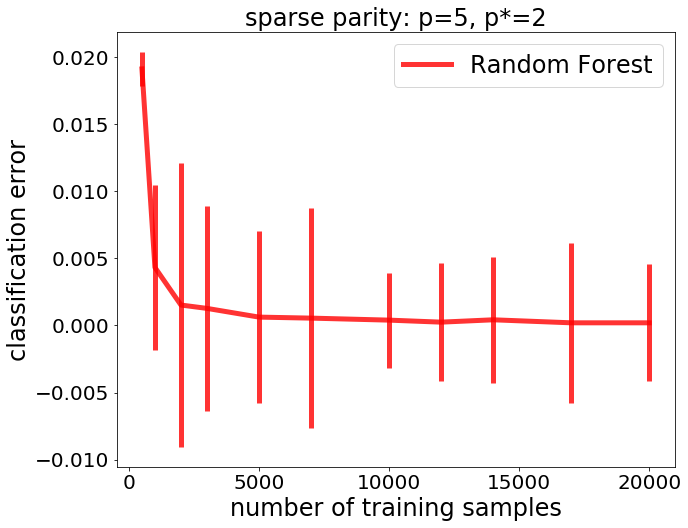

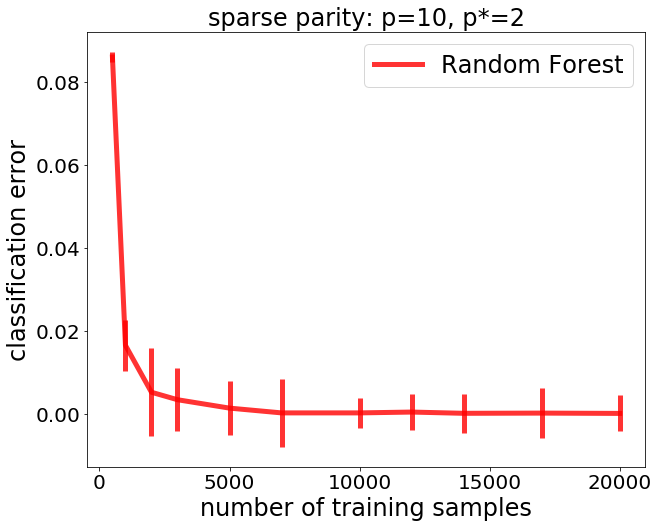

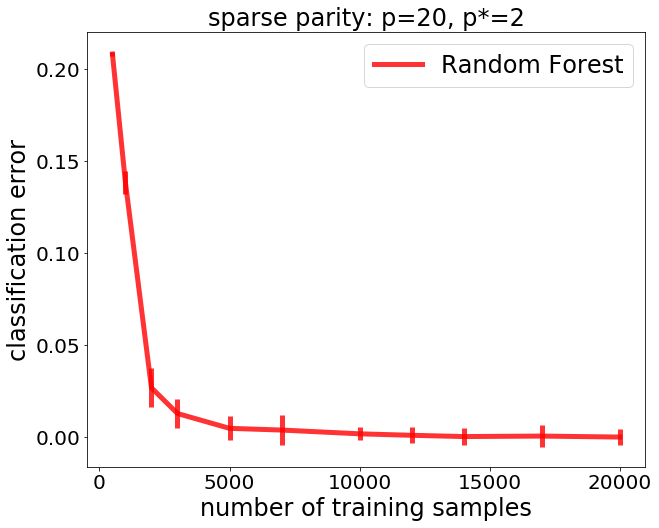

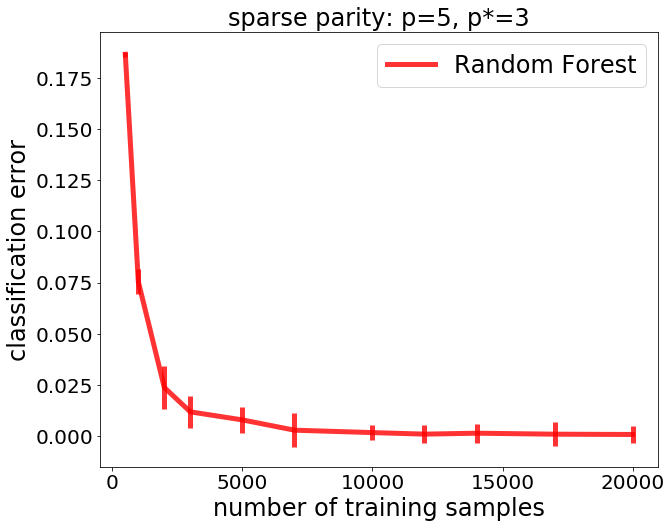

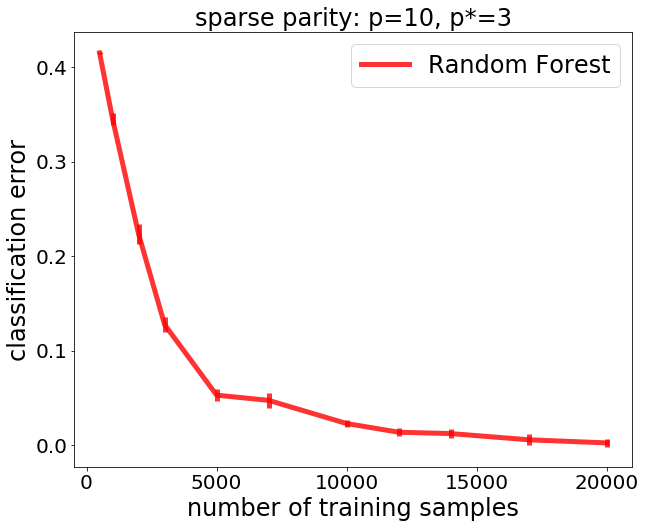

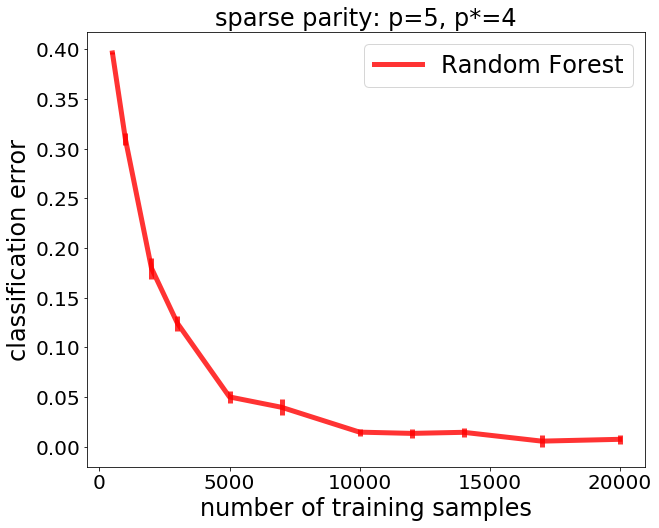

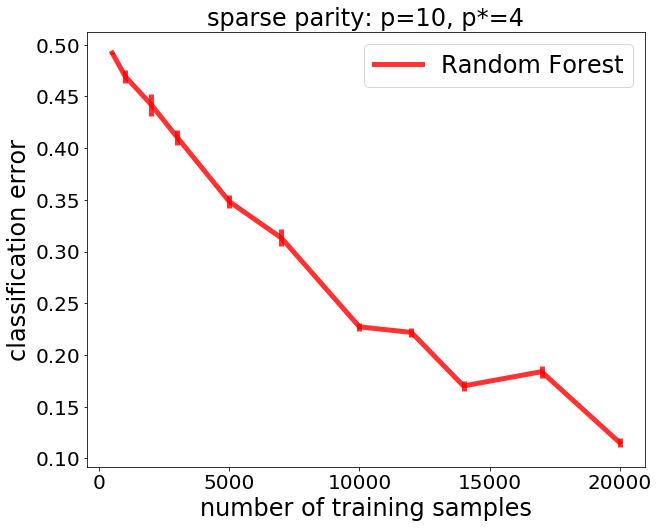

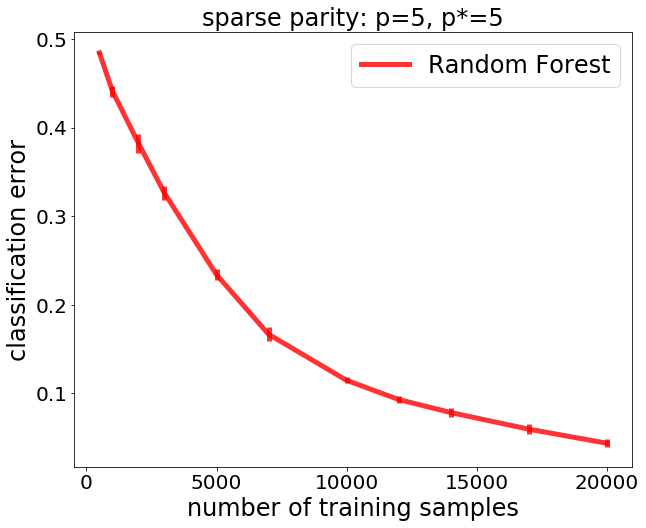

In [13]:
for i in range(len(rf_evolutions)):    
    rf_evolution_mean = np.mean(rf_evolutions[i], axis=1)
    p, p_star = sp_parameters[i]

    yerr_rf = stats.sem(rf_evolution, axis=1)

    fig = plt.figure(figsize=(10, 8))
    ax = plt.subplot(111)

    ax.errorbar(
        training_sample_sizes,
        rf_evolution_mean,
        yerr=yerr_rf,
        linewidth=5,
        c="r",
        alpha=0.8,
        label="Random Forest",
    )

    plt.xticks(range(0, 25000, 5000), fontsize=20)
    plt.yticks(fontsize=20)

    plt.title("sparse parity: p={}, p*={}".format(p, p_star), fontsize=24)
    plt.xlabel("number of training samples", fontsize=24)
    plt.ylabel("classification error", fontsize=24)

    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] for h in handles]
    ax.legend(handles, labels, prop={"size": 24})


In [23]:
sp_parameters = [(5,2),(10,2),(20,2),(5,3),(10,3),(5,4),(10,4),(5,5)]
# sp_parameters = [(5,2),(10,2)]

dn_evolutions = []

for param in sp_parameters:
    p, p_star = param
    dn_evolution = dn(
        training_sample_sizes=training_sample_sizes,
        testing_sample_size=testing_sample_size,
        trials=trials,
        p=p,
        p_star=p_star,
        hidden_nodes=hidden_nodes,
        batch_size=batch_size,
        dn_verbose=dn_verbose,
    )
    
    dn_evolutions.append(dn_evolution)

Trial:  0
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max sample size:  7000
Max sample size:  10000
Max sample size:  12000
Max sample size:  14000
Max sample size:  17000
Max sample size:  20000
Trial:  1
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max sample size:  7000
Max sample size:  10000
Max sample size:  12000
Max sample size:  14000
Max sample size:  17000
Max sample size:  20000
Trial:  2
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max sample size:  7000
Max sample size:  10000
Max sample size:  12000
Max sample size:  14000
Max sample size:  17000
Max sample size:  20000
Trial:  3
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max sample size:  7000
Max sample size:  10000
Max sample size:  12000
Max 

Max sample size:  14000
Max sample size:  17000
Max sample size:  20000
Trial:  1
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max sample size:  7000
Max sample size:  10000
Max sample size:  12000
Max sample size:  14000
Max sample size:  17000
Max sample size:  20000
Trial:  2
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max sample size:  7000
Max sample size:  10000
Max sample size:  12000
Max sample size:  14000
Max sample size:  17000
Max sample size:  20000
Trial:  3
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max sample size:  7000
Max sample size:  10000
Max sample size:  12000
Max sample size:  14000
Max sample size:  17000
Max sample size:  20000
Trial:  4
Max sample size:  500
Max sample size:  1000
Max sample size:  2000
Max sample size:  3000
Max sample size:  5000
Max

In [35]:
dn_evolutions_52_102_202_53_103_54_104_55 = dn_evolutions 
%store dn_evolutions_52_102_202_53_103_54_104_55

Stored 'dn_evolutions_52_102_202_53_103_54_104_55' (list)


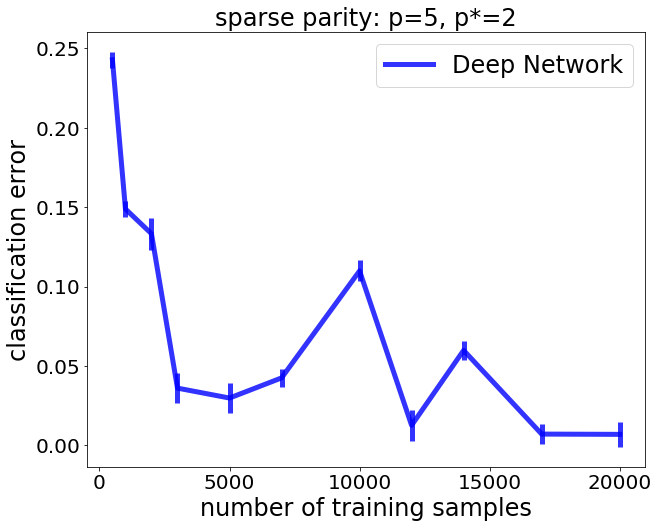

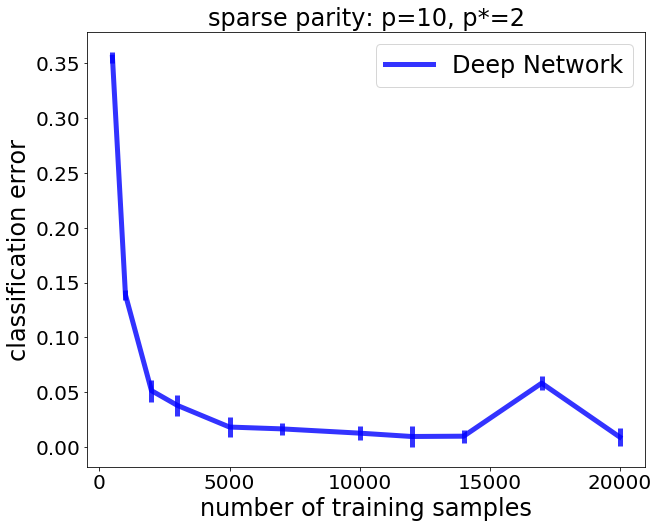

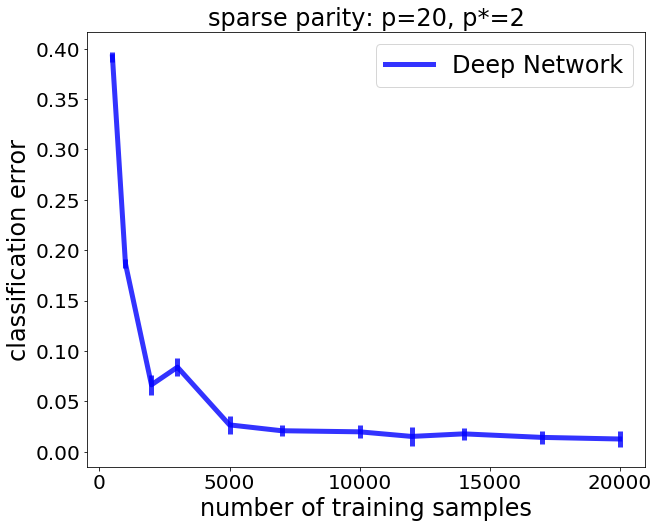

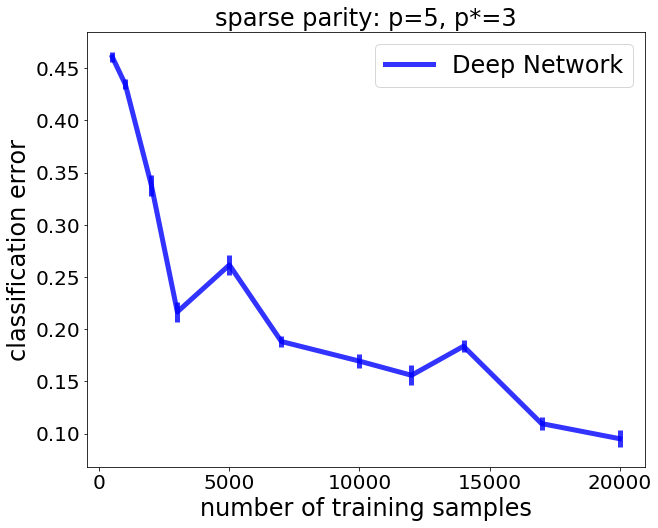

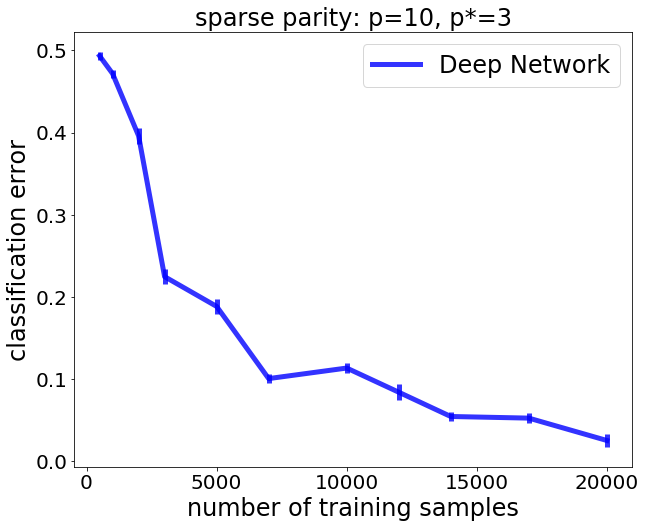

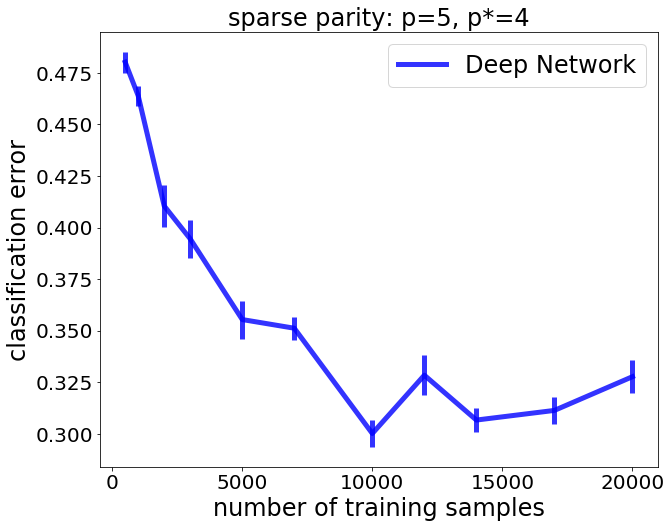

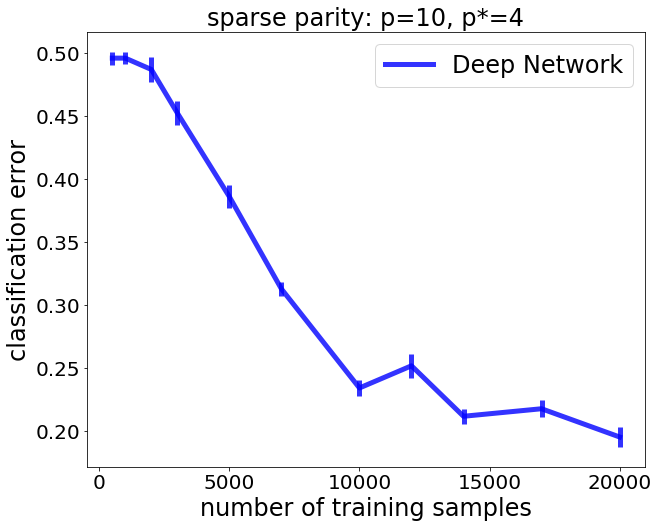

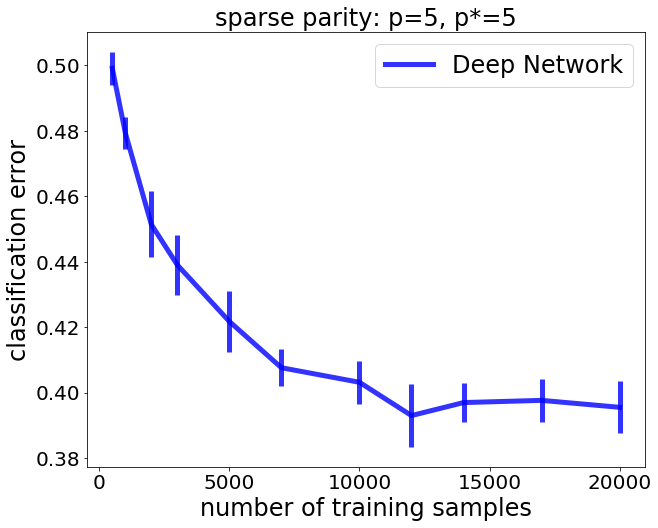

In [25]:
for i in range(len(dn_evolutions)):    
    dn_evolution_mean = np.mean(dn_evolutions[i], axis=1)
    p, p_star = sp_parameters[i]

    yerr_rf = stats.sem(dn_evolution, axis=1)

    fig = plt.figure(figsize=(10, 8))
    ax = plt.subplot(111)

    ax.errorbar(
        training_sample_sizes,
        dn_evolution_mean,
        yerr=yerr_rf,
        linewidth=5,
        c="b",
        alpha=0.8,
        label="Deep Network",
    )

    plt.xticks(range(0, 25000, 5000), fontsize=20)
    plt.yticks(fontsize=20)

    plt.title("sparse parity: p={}, p*={}".format(p, p_star), fontsize=24)
    plt.xlabel("number of training samples", fontsize=24)
    plt.ylabel("classification error", fontsize=24)

    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] for h in handles]
    ax.legend(handles, labels, prop={"size": 24})


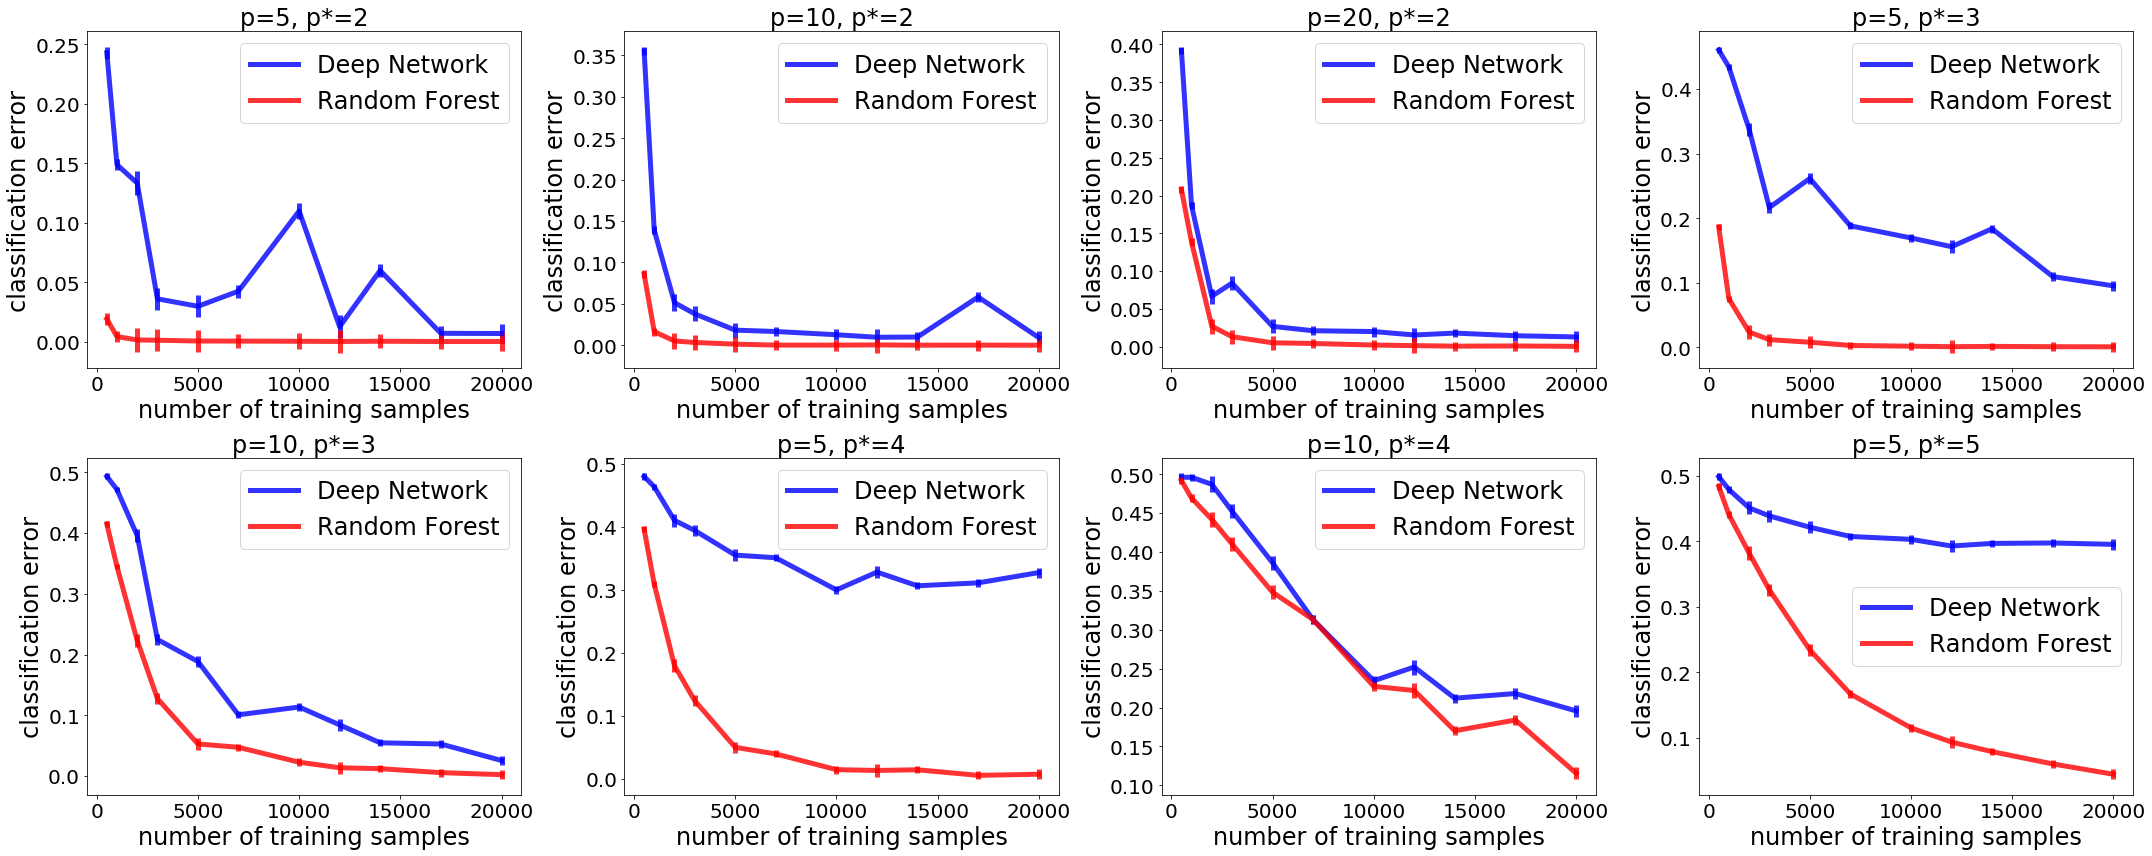

In [36]:
fig = plt.figure(figsize=(30, 12))
for i in range(len(dn_evolutions)):    
    dn_evolution_mean = np.mean(dn_evolutions[i], axis=1)
    rf_evolution_mean = np.mean(rf_evolutions[i], axis=1)
    p, p_star = sp_parameters[i]

    yerr_rf = stats.sem(dn_evolution, axis=1)

    ax = plt.subplot(2,4,i+1)

    ax.errorbar(
        training_sample_sizes,
        dn_evolution_mean,
        yerr=yerr_rf,
        linewidth=5,
        c="b",
        alpha=0.8,
        label="Deep Network",
    )
    
    ax.errorbar(
        training_sample_sizes,
        rf_evolution_mean,
        yerr=yerr_rf,
        linewidth=5,
        c="r",
        alpha=0.8,
        label="Random Forest",
    )
    
    plt.xticks(range(0, 25000, 5000), fontsize=20)
    plt.yticks(fontsize=20)

    plt.title("p={}, p*={}".format(p, p_star), fontsize=24)
    plt.xlabel("number of training samples", fontsize=24)
    plt.ylabel("classification error", fontsize=24)

    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] for h in handles]
    ax.legend(handles, labels, prop={"size": 24})
    plt.tight_layout()

fig.savefig('Final Figures/ss_subplot.png')

### Load the Stored Model (Trained with 100 Trials)

Increasing the number of trials improves the smoothness of the output, but takes additional time to run. The below cell loads in a model trained with 100 trials.

In [ ]:
%store -r rf_evolution_100_trials
%store -r dn_evolution_100_trials

### Plot and Visualize the Results of 100 Trial Output

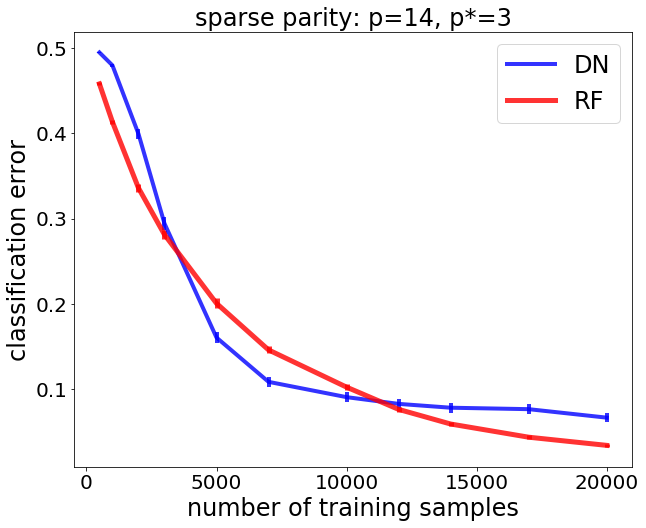

In [10]:
plot_sample_size_experiment(
    rf_evolution_100_trials, dn_evolution_100_trials, training_sample_sizes, 14, 3
)

In [ ]:
def plot_sample_size_experiment(
    rf_evolution, dn_evolution, training_sample_sizes, p, p_star
):
    """
    Plots a figure to visualize the evolution of the RF model and the DN model over
    the range of sample sizes. Error bars are calculated based on the standard
    error of the mean.

    Args:
        rf_evolution : ndarray
            A ndarray of size [len(sample_sizes), trials] containing the RF model
            accuracies across sample sizes and trials.
        dn_evolution : ndarray
            A ndarray of size [len(sample_sizes), trials] containing the DN model
            accuracies across sample sizes and trials.
        training_sample_sizes : list
            A list containing the sample sizes the model was trained with.
        p : int
            The p value for the sparse parity distribution. This is used for plotting
            the title of the figure.
        p_star : int
            The p_star value for the sparse parity distribution. This is used for
            plotting the title of the figure.

    Returns:
        None
    """
    dn_evolution_mean = np.mean(dn_evolution, axis=1)
    rf_evolution_mean = np.mean(rf_evolution, axis=1)

    yerr_dn = stats.sem(dn_evolution, axis=1)
    yerr_rf = stats.sem(rf_evolution, axis=1)

    fig = plt.figure(figsize=(10, 8))
    ax = plt.subplot(111)

    ax.errorbar(
        training_sample_sizes,
        dn_evolution_mean,
        yerr=yerr_dn,
        linewidth=4,
        c="b",
        alpha=0.8,
        label="DN",
    )
    ax.errorbar(
        training_sample_sizes,
        rf_evolution_mean,
        yerr=yerr_rf,
        linewidth=5,
        c="r",
        alpha=0.8,
        label="RF",
    )

    plt.xticks(range(0, 25000, 5000), fontsize=20)
    plt.yticks(fontsize=20)

    plt.title("sparse parity: p={}, p*={}".format(p, p_star), fontsize=24)
    plt.xlabel("number of training samples", fontsize=24)
    plt.ylabel("classification error", fontsize=24)

    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] for h in handles]
    ax.legend(handles, labels, prop={"size": 24})
